## Overview
Drift–diffusion simulation of multi-finger serial presses when visual (window-limited) and memory are integrated.  
- Evidence grid: 5 fingers × press positions; threshold planning + delayed execution.  
- Dual drifts: visual (visibility + sensory planning weights) and memory (planning capacity, always available).  
- Adaptive memory: coefficients can rapidly deactivate after violations and slowly recover.  
- Outputs: movement time (MT), error rate (ER), inter-press intervals (IPIs) 
- Experiments: (1) horizon effects; (2) single violation with adaptive memory; (3) prediction under total alteration.  
- Workflow: set params → define Condition list → run run_all_conditions → plot MT/ER/IPI.  


In [212]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import jit
from matplotlib import rcParams

path_figs = 'Figs/'

custom_palette = {
    'M': sns.color_palette('colorblind')[0],
    'S': sns.color_palette('colorblind')[7],
    'M+S': sns.color_palette('colorblind')[1],
    'M+S (changed)': sns.color_palette('colorblind')[3]
}

finger_colors = {
    'S': sns.color_palette('colorblind')[0],
    'M': sns.color_palette('colorblind')[5],
    'other': 'black',
}
finger_alphas = {
    'S': 1,
    'M': 1,
    'other': 0.5,
}

def set_figure_style(scale="1col", base_font=10):
    """Configure matplotlib for publication-quality figures.

    scale: {'1col','1.5col','2col'} figure width presets (cm basis converted to inches)
    base_font: base font size; other label sizes derived from this.
    """
    widths_cm = {"1col": 7.62, "1.5col": 11.6, "2col": 16.5}
    if scale not in widths_cm:
        raise ValueError("scale must be one of: 1col, 1.5col, 2col")
    width_in = widths_cm[scale] * 0.393701  # cm -> inches
    golden = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden)

    rcParams.update({
        "font.size": base_font,
        "axes.titlesize": base_font + 2,
        "axes.labelsize": base_font - 1,
        "xtick.labelsize": base_font - 3,
        "ytick.labelsize": base_font - 3,
        "legend.fontsize": base_font - 2,
        "figure.titleweight": "bold",
        "axes.linewidth": 0.75,
        "xtick.major.width": 0.75,
        "ytick.major.width": 0.75,
        "text.usetex": False,
        "axes.formatter.use_mathtext": True,
    })

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """Add a bold subpanel label (e.g., 'A', 'B') in axes coordinates."""
    ax.text(position[0], position[1], label, transform=ax.transAxes,
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

# Default style
set_figure_style(scale="1col")

In [213]:
# Purpose: Convert a sequence of digits (1–5) into a (5 x seq_length) drift template.
# These matrices are later scaled by drift coefficients and integrated over time.

def calc_visual_drifts(seq, seq_length):
    # Each column: one press position; each row: finger (0–4). 1 indicates the instructed finger.
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result


def calc_memory_drifts(specific_seq, seq_length):
    # Same construction as visual drifts; conceptually represents learned/internal expectations.
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [214]:
# === Experiment 1: Parameter Initialization ===
# visual_drift_coef / memory_drift_coef: scaling factors applied inside simulate_ddm().
# adaptive coefficients (currently 0) allow dynamic modulation of memory drift after each executed press.
# sensory_param / memory_param: parameter vectors used to allocate planning weights (see planning coef funcs).
# window_sizes: different visible horizons.

visual_drift_coef = 1.0
memory_drift_coef = 0.6
memory_drift_adaptive_coef_activation = 0.0 # how quickly memory drift returns toward baseline after correct press
memory_drift_adaptive_coef_deactivation = 0.0 # how quickly it decays after mismatch

# Diffusion / threshold / decay
visual_delay = 90
motor_delay = 50
diffusion = 3
threshold = 215
alpha = 0.9985
beta = 0.01

# Planning parameters (sensory / memory)
sensory_param = [0.882, 0.3084, 0.8224, 0.257, 0.2056]
memory_param = [0.87400463, 0.72604167, 0.15256944]

# Window sizes 
window_sizes = [1, 2, 3, 7]

# Sequences (primary, target, random, perturbations)
seq = '1352423'
specific_seq = '1352423'
random_seq = '4534132'
specific_seq_changed_one_digit = '1353423'
seq_length = len(seq)

print("Experiment 1 parameters initialized.")

Experiment 1 parameters initialized.


In [215]:
# ============================== CELL: Planning Coefficient Functions & Utilities ==============================
# get_planning_coefs / sensory_planning_coefs:
#   Produce weights for sensory (visual) planning across lookahead positions.
# memory_planning_coefs:
#   Produce weights governing memory-based (internal) planning horizon.
# check_evidence_to_seq:
#   Validates that pressed finger matches presented sequence.
# calculate_IPI_from_press_time:
#   Converts absolute press timestamps into an array of inter-press intervals (first = reaction time).
# changed_digit_idx:
#   Utility to locate perturbation index between two sequences (used for violation analyses).


@jit(nopython=True)
def get_planning_coefs(capacity, param):
    """Wrapper returning sensory planning coefficients.

    capacity : int   current effective sensory planning capacity (<= planning_capacity & visible window)
    param    : list  parameter vector controlling weight distribution across lookahead positions
    """
    return sensory_planning_coefs(capacity, param)

@jit(nopython=True)
def sensory_planning_coefs(capacity, param):
    """Sensory planning coefficients.
    Allocation rule:
      capacity=1 -> deterministic [1]
      capacity=2 -> first two params
      capacity>=3 -> next three params (truncated if capacity smaller than 3)
    """
    theta = np.zeros(capacity)
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]
    return theta

@jit(nopython=True)
def memory_planning_coefs(capacity, param):
    """Memory planning coefficients.
    Allocation rule:
      1 -> [1]
      2 -> [p0, 1-p0]
      >=3 -> [p1, p2, remainder]
    Ensures weights sum to 1 for memory planning.
    """
    theta = np.zeros(capacity)
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = 1 - theta[0]
    elif capacity >= 3:
        theta[0] = param[1]
        theta[1] = param[2]
        theta[2] = 1 - theta[0] - theta[1]
    return theta

def check_evidence_to_seq(evidence, seq):
    """Return True if argmax finger at every press index matches the target seq digits."""
    for press in range(len(seq)):
        if not (np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

def calculate_IPI_from_press_time(press_times):
   """Convert absolute press times -> IPI array (first element treated as latency from trial start)."""
   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])

def changed_digit_idx(seq1, seq2):
    """Return index of first differing digit between two sequences, or -1 if identical."""
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            return i
    return -1

In [216]:
# ============================== CELL: Core Simulator (simulate_ddm) ==============================
# Purpose: Time-step simulation of accumulating evidence for each finger × press position.
# Key mechanics:
#   - visual_delay_queue: enforces delayed visibility of upcoming items.
#   - motor_delay_queue: press execution lag after plan threshold crossing.
#   - planning vs memory drifts: sensory limited by visible window and planning capacity; memory spans capacity.
#   - adaptive memory drift: coefficient nudged toward baseline or zero based on correctness of executed press.
# Stopping condition: all presses executed or max_time reached.



@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time,
                 seq_length, window_size, planning_capacity, sensory_param, memory_param, visual_delay, motor_delay, alpha, beta, memory_drift_coef,
                 memory_drift_adaptive_coef_activation, memory_drift_adaptive_coef_deactivation,):
    """Simulate evidence accumulation for a finger sequence.

    Returns
    -------
    press_times : float[seq_length]
        Execution times (NaN where not executed).
    evidence : array (5, seq_length)
        Final evidence values per finger/press.
    """
    evidence = np.zeros((5, seq_length))
    time = 0.0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    effective_planning_capacity_motor = planning_capacity
    visible_window_size = 0

    planning_coefs = get_planning_coefs(effective_planning_capacity, sensory_param)
    motor_planning_coefs = memory_planning_coefs(effective_planning_capacity_motor, memory_param)

    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta

    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        # Apply leakage + noise
        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned: current_press_planned + 1] += diffusion_term * random_terms[:, current_press_planned: current_press_planned + 1, t_index]

        # Sensory (visual) drift limited by visible window & sensory planning capacity.
        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef

        # Memory drift extends to full memory planning capacity (independent of visibility).
        for press in range(current_press_planned, min(seq_length, current_press_planned + effective_planning_capacity_motor)):
            evidence[:, press] += motor_planning_coefs[press - current_press_planned] * drifts_memory_dt[:, press] * current_memory_coef
       
        # Non-negative enforcement to prevent unphysical negative evidence.
        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])

        # Threshold crossing => press planned; schedule motor execution after motor_delay.
        if (evidence[:, current_press_planned: current_press_planned + 1] >= threshold).any():
            visible_window_size -= 1
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            effective_planning_capacity_motor = planning_capacity
            try:
                planning_coefs = get_planning_coefs(effective_planning_capacity, sensory_param)
            except:
                return press_times, evidence
            motor_planning_coefs = memory_planning_coefs(effective_planning_capacity_motor, memory_param)

        # Execute pending press when its motor delay completes.        
        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time
            if specific_seq is not None:
                # Adaptive memory drift update: pull toward baseline if match, toward zero if mismatch.                
                if seq[current_press_execed] == specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
            current_press_execed += 1
            if current_press_execed == seq_length:
                break

        # Reveal new visual items when their delay elapses.
        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            effective_planning_capacity_motor = planning_capacity
            try:
                planning_coefs = get_planning_coefs(effective_planning_capacity, sensory_param)
            except:
                return press_times, evidence
            motor_planning_coefs = memory_planning_coefs(effective_planning_capacity_motor, memory_param)

    return press_times, evidence

In [217]:
class DriftDiffusionModel:
    """Sequence drift-diffusion model.

    Simulates parallel evidence accumulation for 5 effectors (fingers) over a discrete press sequence.
    Two drift sources:
      * sensory (visual)    -> gated by visible window & sensory planning capacity
      * memory (internal)   -> full planned horizon up to planning_capacity

    Adaptive modulation reduces visual drift for matched presses and adjusts memory drift depending on correctness.
    """
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,
                 seq_length = 11, window_size = 2, planning_capacity = 3, sensory_param = 3, memory_param = 3,
                 visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001, memory_drift_coef = 0.7,
                 memory_drift_adaptive_coef_activation = memory_drift_adaptive_coef_activation, memory_drift_adaptive_coef_deactivation = memory_drift_adaptive_coef_deactivation):
        # Sequence definitions
        self.seq_length = seq_length
        self.seq = seq                    # Presented (could be changed)
        self.specific_seq = specific_seq  # Trained/target sequence for correctness & memory drifts
        self.presses = [None for _ in range(seq_length)]
        self.press_times = [None for _ in range(seq_length)]

        # Planning / window controls
        self.window_size = window_size
        self.planning_capacity = planning_capacity
        self.sensory_param = sensory_param
        self.memory_param = memory_param

        # Drift templates
        assert visual_drifts.shape == (5, seq_length), "There must be exactly 5 drift rows."
        self.visual_drifts = visual_drifts
        self.memory_drifts = memory_drifts

        # Core DDM parameters
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.alpha = alpha  # decay preservation per step (self-inhibition matrix diagonal scaling)
        self.beta = beta    # lateral inhibition weight blending
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay

        # Memory adaptation parameters
        self.memory_drifts_coef = memory_drift_coef
        self.memory_drifts_adaptive_coef_activation = memory_drift_adaptive_coef_activation
        self.memory_drifts_adaptive_coef_deactivation = memory_drift_adaptive_coef_deactivation

    def _compute_ipis(self, press_times):
        """Return inter-press intervals given absolute press times."""
        return calculate_IPI_from_press_time(press_times)

    def simulate(self):
        """Run a single simulation returning (IPIs, evidence)."""
        press_times, evidence = simulate_ddm(
            self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
            self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length,
            self.window_size, self.planning_capacity, self.sensory_param, self.memory_param,
            self.visual_delay, self.motor_delay, self.alpha, self.beta, self.memory_drifts_coef,
            self.memory_drifts_adaptive_coef_activation, self.memory_drifts_adaptive_coef_deactivation
        )
        self.press_times = press_times
        return self._compute_ipis(self.press_times), evidence

In [218]:
# ============================== CELL: Simulation & Plotting Helpers ==============================
# DDMCoreParams: immutable container for core simulational constants.
# Condition: defines one experimental condition (visual vs memory sequence, optional change index).
# build_model(): convenience factory for DriftDiffusionModel with given condition + window size.
# simulate_condition(): runs multiple simulations per window size; collects MT, ER (+ optional IPI detail).
# run_all_conditions(): orchestrates calling simulate_condition over a list of Condition objects.
# plot_mt / plot_er: quick summary point plots (mean only; no error bars currently).
# ipi_around_change(): aggregates IPI values relative to sequence change position.
# white_fill_markers(): aesthetic helper to enforce hollow markers.



from dataclasses import dataclass
from typing import List, Optional, Iterable, Tuple, Dict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Expect these to be already defined in notebook and imported via this module ---
# calc_visual_drifts, calc_memory_drifts, DriftDiffusionModel, check_evidence_to_seq

@dataclass
class DDMCoreParams:
    diffusion: float
    threshold: float
    visual_delay: int
    motor_delay: int
    alpha: float
    beta: float
    dt: float = 1.0
    max_time: int = 10000
    planning_capacity: int = 3

@dataclass
class Condition:
    name: str
    visual_seq: str                # sequence shown (seq argument to model)
    memory_seq: Optional[str]      # sequence expected to be memorized (None => zeros)
    changed_index: Optional[int] = None  # index of changed digit (None if no change)



def build_model(cond: Condition,
                window_size: int,
                seq_length: int,
                sensory_param,
                memory_param,
                ddm: DDMCoreParams,
                memory_drift_coef: float,
                memory_drift_adaptive_coef_activation: float = 0.0,
                memory_drift_adaptive_coef_deactivation: float = 0.0):
    visual_drifts = calc_visual_drifts(cond.visual_seq, seq_length)


    if cond.memory_seq is None:
        memory_drifts = np.zeros_like(visual_drifts)
    else:
        memory_drifts = calc_memory_drifts(cond.memory_seq, seq_length)
    return DriftDiffusionModel(
        cond.visual_seq,
        cond.memory_seq,  # specific_seq argument
        visual_drifts,
        memory_drifts,
        ddm.diffusion,
        ddm.threshold,
        dt=ddm.dt,
        max_time=ddm.max_time,
        seq_length=seq_length,
        window_size=window_size,
        planning_capacity=ddm.planning_capacity,
        sensory_param=sensory_param,
        memory_param=memory_param,
        visual_delay=ddm.visual_delay,
        motor_delay=ddm.motor_delay,
        alpha=ddm.alpha,
        beta=ddm.beta,
        memory_drift_coef=memory_drift_coef,
        memory_drift_adaptive_coef_activation=memory_drift_adaptive_coef_activation,
        memory_drift_adaptive_coef_deactivation=memory_drift_adaptive_coef_deactivation
    )

def simulate_condition(cond: Condition,
                       window_sizes: Iterable[int],
                       n_sims: int,
                       seq_length: int,
                       sensory_param,
                       memory_param,
                       ddm_params: DDMCoreParams,
                       memory_drift_coef: float,
                       activation_coef: float = 0.0,
                       deactivation_coef: float = 0.0,
                       keep_all_ipis: bool = False) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    """Run batch simulations for one condition across window sizes."""
    mt_rows = []
    er_rows = []
    ipi_rows = [] if keep_all_ipis else None

    for w in window_sizes:
        model = build_model(cond, w, seq_length, sensory_param, memory_param,
                            ddm_params, memory_drift_coef,
                            activation_coef, deactivation_coef)
        for sim in range(n_sims):
            IPIs, evidence = model.simulate()
            if np.isnan(IPIs).any():
                continue
            correct = check_evidence_to_seq(evidence, cond.visual_seq)
            er_rows.append((cond.name, w, sim, 0 if correct else 1))
            if correct:
                # Movement time = sum of subsequent IPIs (excluding reaction time)
                mt_rows.append((cond.name, w, sim, float(np.nansum(IPIs[1:]))))
                if keep_all_ipis:
                    for idx, val in enumerate(IPIs):
                        ipi_rows.append((cond.name, w, sim, idx, float(val)))

    mt_df = pd.DataFrame(mt_rows, columns=["condition", "windowSize", "sim", "MT"])
    er_df = pd.DataFrame(er_rows, columns=["condition", "windowSize", "sim", "ER"])
    ipi_df = None
    if keep_all_ipis and ipi_rows:
        ipi_df = pd.DataFrame(ipi_rows, columns=["condition", "windowSize", "sim", "press_idx", "IPI"])
    return (mt_df.merge(er_df, on=["condition","windowSize","sim"], how="outer"), ipi_df)

def run_all_conditions(conditions: List[Condition],
                       window_sizes: Iterable[int],
                       n_sims_map: Dict[str,int],
                       seq_length: int,
                       sensory_param,
                       memory_param,
                       ddm_params: DDMCoreParams,
                       memory_drift_coef: float,
                       activation_coef: float = 0.0,
                       deactivation_coef: float = 0.0,
                       keep_all_ipis: bool = False) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    """Loop over all conditions, concatenate results."""
    all_metrics = []
    all_ipis = []
    for cond in conditions:
        n_sims = n_sims_map.get(cond.name, list(n_sims_map.values())[0])
        metrics, ipi_df = simulate_condition(
            cond, window_sizes, n_sims, seq_length, sensory_param, memory_param,
            ddm_params, memory_drift_coef, activation_coef, deactivation_coef,
            keep_all_ipis=keep_all_ipis
        )
        all_metrics.append(metrics)
        if keep_all_ipis and ipi_df is not None:
            all_ipis.append(ipi_df)
    metrics_df = pd.concat(all_metrics, ignore_index=True)
    ipis_df = pd.concat(all_ipis, ignore_index=True) if (keep_all_ipis and all_ipis) else None
    return metrics_df, ipis_df

def plot_mt(metrics_df: pd.DataFrame, palette: Dict[str,str]):
    # filter M+S (changed)
    metrics_df = metrics_df[~((metrics_df.condition == "M+S (changed)"))]
    sns.pointplot(data=metrics_df, x="windowSize", y="MT", hue="condition",
                  errorbar=None, dodge=True, palette=palette)
    plt.xlabel("Visible Horizon")
    plt.ylabel("Movement Time")
    sns.despine(trim=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


def plot_er(metrics_df: pd.DataFrame, palette: Dict[str,str]):
    sns.pointplot(data=metrics_df, x="windowSize", y="ER", hue="condition",
                  errorbar=None, dodge=True, palette=palette)
    plt.xlabel("Visible Horizon")
    plt.ylabel("Error Rate")
    sns.despine(trim=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


def ipi_around_change(ipis_df: pd.DataFrame,
                      change_idx: int,
                      lookback: int,
                      palette: Dict[str,str]):
    """
    Aggregate IPI values by distance to change index (press_idx - change_idx).
    Assumes ipis_df includes columns: condition, press_idx, IPI.
    """
    df = ipis_df.copy()
    df["dist_to_change"] = df.press_idx - change_idx
    df = df[df.dist_to_change.between(-lookback+1, lookback-1)]
    # Average across window sizes per sim to collapse like original code:
    grp = (df.groupby(["condition","sim","dist_to_change"])
             .agg(MeanIPI=("IPI","mean")).reset_index())
    sns.pointplot(data=grp, x="dist_to_change", y="MeanIPI",
                  hue="condition", errorbar=None, dodge=True, palette=palette)
    plt.xlabel("Distance to Change Press")
    plt.ylabel("Inter-Press Interval (a.u.)")
    sns.despine(trim=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return grp

def white_fill_markers():
    for artist in plt.gcf().findobj(match=plt.Line2D):
        if artist.get_marker() != 'None':
            artist.set_markerfacecolor('white')



core_params = DDMCoreParams(
    diffusion = diffusion, 
    threshold = threshold,
    visual_delay = visual_delay,
    motor_delay = motor_delay,
    alpha = alpha, 
    beta = beta,
    dt = 1.0,
    max_time = 10000,
    planning_capacity = 3
)

## Experiment 1

- Movement Time is faster with longer visible horizon. 
- Error rate is lower with longer visible horizon during violations

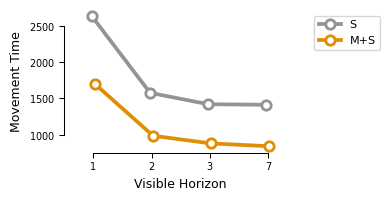

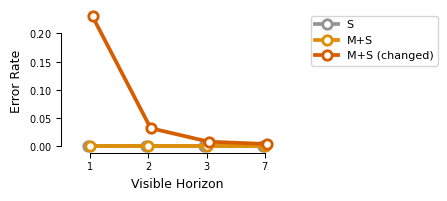

In [219]:
conditions_exp1 = [
    Condition("S",       visual_seq=random_seq,
              memory_seq=None),
    Condition("M+S",       visual_seq=specific_seq,
              memory_seq=specific_seq),
    Condition("M+S (changed)", visual_seq=specific_seq_changed_one_digit,
              memory_seq=specific_seq,
              changed_index=changed_digit_idx(specific_seq_changed_one_digit, specific_seq))
]

metrics_e1, _ = run_all_conditions(
    conditions_exp1,
    window_sizes=window_sizes,
    n_sims_map={"S":100, "M+S":100, "M+S (changed)":500},
    seq_length=seq_length,
    sensory_param=sensory_param,
    memory_param=memory_param,
    ddm_params=core_params,
    memory_drift_coef=memory_drift_coef
)

plt.figure()
plot_mt(metrics_e1, palette=custom_palette)
white_fill_markers()
plt.show()

plt.figure()
plot_er(metrics_e1, palette=custom_palette)
white_fill_markers()
plt.show()


## Experiment 2

- single violations produce slowdown on the violated press 
- violations ***do not*** cause a slowdown before the violation
- Quick memory deactivation and slow memory reactivation to account for behavior after the violation

In [204]:
# === Experiment 2: Parameter Initialization ===
seq = '13524232514'
specific_seq = '13524232514'
random_seq = '45341323141'
specific_seq_changed = '13524213333'
specific_seq_changed_one_digit = '13524212514'
seq_length = len(seq)

window_sizes = [2, 3, 4, 11]

visual_drift_coef = 1.0
memory_drift_coef = 0.3
memory_drift_adaptive_coef_activation = 0.0
memory_drift_adaptive_coef_deactivation = 0.0

print("Experiment 2 parameters initialized.")

Experiment 2 parameters initialized.


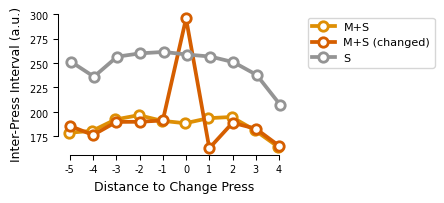

In [205]:
# ...existing code...
lookback_window = 6
change_idx = 6


conditions_e2 = [
    Condition("S", visual_seq=random_seq,
              memory_seq=None, changed_index=change_idx),
    Condition("M+S", visual_seq=specific_seq,
              memory_seq=specific_seq, changed_index=change_idx),
    Condition("M+S (changed)", visual_seq=specific_seq_changed_one_digit,
              memory_seq=specific_seq, changed_index=change_idx)
]

metrics_e2, ipis_e2 = run_all_conditions(
    conditions_e2,
    window_sizes=window_sizes,
    n_sims_map={"S":100, "M+S":100, "M+S (changed)":100},
    seq_length=seq_length,
    sensory_param=sensory_param,
    memory_param=memory_param,
    ddm_params=core_params,
    memory_drift_coef=memory_drift_coef,
    activation_coef=memory_drift_adaptive_coef_activation,
    deactivation_coef=memory_drift_adaptive_coef_deactivation,
    keep_all_ipis=True
)

plt.figure()
ipi_around_change(ipis_e2, change_idx=change_idx, lookback=lookback_window, palette=custom_palette)
white_fill_markers()
plt.show()

In [206]:
# Quick deactivation (deactivation >> 0) and slow activation (activation << 1)

memory_drift_adaptive_coef_activation = 0.3
memory_drift_adaptive_coef_deactivation = 0.9

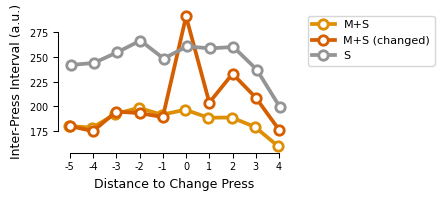

In [207]:
lookback_window = 6
change_idx = 6

metrics_e2, ipis_e2 = run_all_conditions(
    conditions_e2,
    window_sizes=window_sizes,
    n_sims_map={"S":100, "M+S":100, "M+S (changed)":100},
    seq_length=seq_length,
    sensory_param=sensory_param,
    memory_param=memory_param,
    ddm_params=core_params,
    memory_drift_coef=memory_drift_coef,
    activation_coef=memory_drift_adaptive_coef_activation,
    deactivation_coef=memory_drift_adaptive_coef_deactivation,
    keep_all_ipis=True
)

plt.figure()
ipi_around_change(ipis_e2, change_idx=change_idx, lookback=lookback_window, palette=custom_palette)
white_fill_markers()
plt.show()

## Experiment 3 – Prediction
- Quick deactivation predicts similar performance after the violation to random 

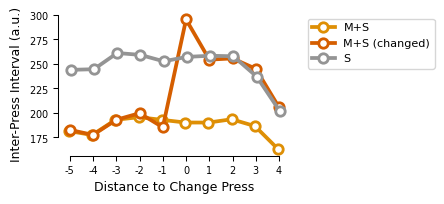

In [208]:
lookback_window = 6
change_idx = 6

conditions_e3 = [
    Condition("S", visual_seq=random_seq,
              memory_seq=None, changed_index=change_idx),
    Condition("M+S", visual_seq=specific_seq,
              memory_seq=specific_seq, changed_index=change_idx),
    Condition("M+S (changed)", visual_seq=specific_seq_changed,
              memory_seq=specific_seq, changed_index=change_idx)
]

metrics_e3, ipis_e3 = run_all_conditions(
    conditions_e3,
    window_sizes=window_sizes,
    n_sims_map={"S":100, "M+S":100, "M+S (changed)":100},
    seq_length=seq_length,
    sensory_param=sensory_param,
    memory_param=memory_param,
    ddm_params=core_params,
    memory_drift_coef=memory_drift_coef,
    activation_coef=memory_drift_adaptive_coef_activation,
    deactivation_coef=memory_drift_adaptive_coef_deactivation,
    keep_all_ipis=True
)

plt.figure()
ipi_around_change(ipis_e3, change_idx=change_idx, lookback=lookback_window, palette=custom_palette)
white_fill_markers()
plt.show()